## Idea - Model

<img src="./img/guided_diffusion_idea.jpeg" alt="image" width="50%" height="auto">

$\ln$ 을 다 지운 거를 생각해야 한다

<img src="./img/guided_diffusion_idea_2.jpeg" alt="image" width="50%" height="auto">

sampling과 learning을 이 사항들을 반영하도록 `DiffusionModel`에서 바꿨다.

## Idea - modified Unet

기존 `Unet`에서 conditioning variable을 받아야 한다. MNIST label을 이용하면 0 ~ 9까지 conditioning variable이 나오는데, 이거를 $t$ embedding 처럼 망에 집어넣는거다. 

기존 `Unet`은 $t$ embedding을 `ResNetBlock`에서 받아서 처리했는데, 두번 받아서 처리하니까, 두번째 `ResNetBlock`에서는 conditioning variable을 embedding한 값으로 받아서 처리하도록 하면 될 거 같음.

```python
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t) # implement conditioning variable embedding at here
            x = attn(x)
            h.append(x)

            x = downsample(x)
```

이 사항을 일단 `GuidedUnet`에 반영했다. 

In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *
from DiffusionModel import *
from GuidedUnet import *

In [10]:
# define hyperparameters

image_size = 32
channel = 1

batchsize = 128

timestep = 300

lr = 1e-3
epochs = 1

delta = 0.5

dimmults = (1,2,4,8)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda:0


In [11]:
# get MNIST datasets

data_root = './data'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])

train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

data_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)

In [4]:
# define linear beta schedule

linear_betas, linear_alphas, linear_sqrt_alphas, linear_sqrt_one_minus_alphas, linear_sampling_1, linear_sampling_2 = total_beta_schedule(linear_beta_schedule, timestep)

# define linear network and optimizer_linear

linear_net = GuidedUnet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
linear_net.to(device)

linear_optimizer = optim.Adam(linear_net.parameters(), lr=lr)

In [5]:
# train - linear

linear_training_loss, linear_training_taken_step, linear_taken_step = training_guided(data_loader, epochs, timestep, linear_net, linear_optimizer, device, 
                                                                               linear_sqrt_alphas, linear_sqrt_one_minus_alphas)


>> epoch : 0 / with condition variable


c:\Users\saych\OneDrive\document\usurf\diffusion\DiffusionModel.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(labels, device=device).long()


Loss:  0.06978446245193481
Loss:  0.04863841086626053
Loss:  0.04389204829931259
Loss:  0.04036669060587883
>> epoch : 1 // without conditioning variable
Loss:  0.04715804010629654
Loss:  0.031197907403111458
Loss:  0.040592413395643234
Loss:  0.03483201935887337
Loss:  0.028522077947854996


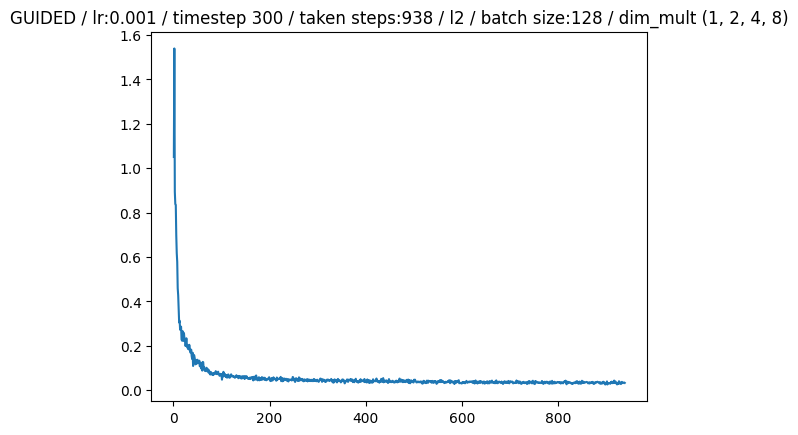

In [6]:
# plot loss linear 

x = np.array(linear_training_taken_step)
y = np.array([x.cpu().detach().numpy() for x in linear_training_loss])

plt.plot(x, y)
plt.title(f"GUIDED / lr:{lr} / timestep {timestep} / taken steps:{linear_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
plt.show()

In [7]:
# save linear model
save_net_betas(linear_net, linear_betas, linear_sampling_1, linear_sampling_2, "linear_guided")

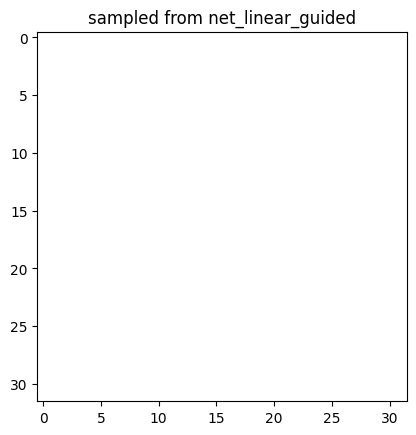

In [8]:
# plot sampled image - linear
condition = 1

res:torch.Tensor = sampling_guided(timestep, condition, delta, linear_betas, linear_sampling_1, linear_sampling_2, linear_net, device)

plt.figure()
plt.title("sampled from net_linear_guided")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

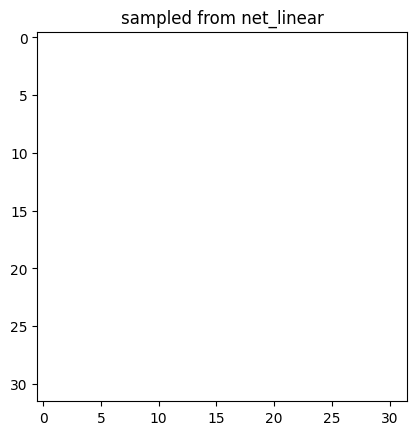

In [9]:
# sample from loaded models

loaded_linear_net = GuidedUnet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
loaded_linear_net, loaded_linear_betas, loaded_linear_sampling_1, loaded_linear_sampling_2 = load_net_betas(loaded_linear_net, device, "linear_abstract")


res:torch.Tensor = sampling_guided(timestep, condition, delta, loaded_linear_betas, loaded_linear_sampling_1, loaded_linear_sampling_2, loaded_linear_net, device)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')